# Development Notebooks

## Sampling & Weighting

Calcuates the base/breach scenario weight for a specific number of annual exceedance probabilities (AEPs) within a given range of AEP. The weights are assigned to specific events using the mean flow frequency (AEP and discharge) to relate the event's peak discharge (found in PeakFlow_MetaData.csv) to the AEP and its corresponding weight. The mean flow frequency curve is calculated using the discharge for a range of AEPs and confidence limits (CLs) from HEC-SSP. The weight for a specific event is then divided among the base and breach scenarios for that event using Augusta_Fluvial_weights.csv. The weight of the breach scenarios are then adjusted by the number of breach scenarios and the extra weight is added to the base. The resulting weights are used to calculate the average annual loss (AAL) for that location. 

Dependencies: .rpt files for the specific gage, peak discharge for modeled events from PeakFlow_MetaData.csv, base/breach scenario proportions from Augusta_Fluvial_weights.csv, and libraries in pmtools.


sputnam@dewberry.com

3.4.2019

---

### Specify the number of and range for the AEP:

In [1]:
min_val=2.0 #The minimum recurrance interval
max_val=3000.0 #(r); the maximum recurrance interval. 11500 is approximately the max we need to capture the most extreme events

nbin=300 #[15,30 50,75,100,150]; [15,20,40,60,80,100,120,150,200,250] #The number of recurrance intervals/AEPs which is also the number of bins over the interval defined above

nevents=1 #(s); the number of events we want to find whose discharge is closest to the mean

gage_ID='02197000' # USGS stream gage ID for Augusta, GA 

### Load libraries and Python options:

In [2]:
import sys
sys.path.append('../../pmtools')
from ssp_ops import* #If using outputs from the older version of HEC-SSP, use this library
from sampler import *
from stats_plotter import *
from glob import glob
%matplotlib inline
#pd.options.mode.chained_assignment = None #Add the slice from dataframe warnings

### 1. Calculate the mean flow frequency curve using the results from HEC-SSP (USACE Method):

##### Load the output files from HEC-SSP:

In [3]:
os.chdir('..')
root_dir=os.getcwd() #The root directory, which is set to the current working directory

ssp_results = glob(os.path.join(os.path.join(root_dir, '**',gage_ID),'**','*.rpt'), recursive=True) # Find a folder labeled with the gage ID and then all of the .rpt files within that folder.

for i, f in enumerate(ssp_results): # Print list of all of the .rpt files for the specific gage
    print(i, os.path.basename(f)) 

0 02197000_60.rpt
1 02197000_70.rpt
2 02197000_80.rpt
3 02197000_90.rpt
4 02197000_95.rpt
5 02197000_99.rpt
6 02197000_995.rpt
7 02197000_999.rpt


#####  Create a summary table:

In [4]:
df = make_ssp_table(ssp_results) #Create the data table using the .rpt files from above. 

if not np.all(np.diff([np.sum(df.iloc[:,i]) for i in range(df.shape[1])]) > 0): # Test to make sure that the sum of each column is increasing across the dataframe (with CL), if not set the table to none. 
    print("Q not increasing with CL as expected, check data")
    df=None

df.head()

,0.001,0.005,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99,0.995,0.999
AEP,,,,,,,,,,,,,,,,,
1.000000e-09,1035320.6,1260401.3,1402517.7,1970018.6,2447269.1,3325180.7,4303814.7,5533082.4,7218988.4,9767877.4,14183624.0,23834445.6,60153136.0,168829997.1,1.320515e+09,2.315355e+09,7.391380e+09
2.000000e-09,970123.8,1172605.7,1299706.2,1802622.1,2220993.7,2982466.9,3821641.5,4864827.4,6280287.1,8394899.8,12005782.9,19744365.5,47905941.1,128484294.9,9.335400e+08,1.601023e+09,4.883666e+09
5.000000e-09,888342.3,1063690.0,1172905.9,1599860.7,1949971.8,2578327.3,3260386.0,4096686.7,5215490.8,6860775.3,9617202.0,15373834.1,35418865.5,89488941.6,5.900284e+08,9.828653e+08,2.823884e+09
1.000000e-08,829676.9,986435.0,1083497.6,1459483.2,1764454.5,2306019.8,2887153.9,3592338.2,4525696.6,5882011.5,8121830.4,12709182.6,28161535.2,68032158.1,4.168973e+08,6.794264e+08,1.866180e+09
2.000000e-08,773686.5,913407.3,999409.4,1329510.4,1594351.2,2059689.0,2553307.8,3146100.0,3922352.2,5037011.7,6851469.5,10495965.2,22373655.4,51693448.2,2.944834e+08,4.695821e+08,1.233322e+09


##### Transform the SSP results:

In [5]:
CL= list(map(float, df.columns)) #Extract the confidence limits from the table above

AEP=df.index #Extract the annual exceedence probabilities from the table above

data = np.log10(df) #Take the log10 of the discharge data contained within the summary table from above.

CLz=zvar(CL) #Convert the confidence limits to their standard normal z variate

AEPz=zvar(AEP) #Convert the annual exceedence probability to their standard normal z variate

##### Determine the AEP for each flow and CL:

In [6]:
Q=binQ(data) #Bin the log flow from the minimum to the maximum observed discharge for any confidence limit or annual exceeedance probability. The number of bins corresponds to the number of AEPs

res=interp_AEP(data,Q,CLz,AEPz, Extrapolate=True) #Perform the interpolation/extrapolation to calculate the CL(z) and binned discharge (log). Choose either True or False where True indicates that you do want to extrapolate while False indicates that you want to only interpolate within the bounds of the minimum and maximum discharge for a specific CL  

##### Transform the interpolated/extrapolated AEP results by taking the inverse of the standard normal z variate 

In [7]:
restrans=zvar_inv(res, CL) #Take the inverse of the normal zvariate and pass the original CL. Q is still in log10

##### Calculate, transform, and plot the mean (expected value) of the AEP for each flow:

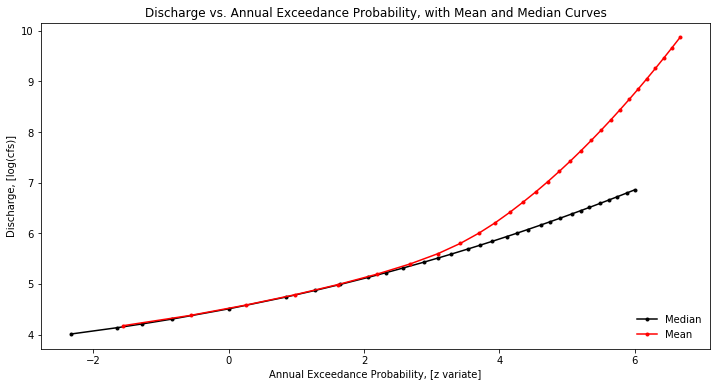

In [8]:
AEPm=mean_AEP(restrans) #Calculate the mean (expected) value of the AEP for each flow; this mean is equal to the area under the CDF. Here we use the trapezoidal rule for integration. 

AEPmz=zvar(AEPm) #Transform this mean AEP to the standard normal z variate

plot_ssp_meanmed(AEPz,data,AEPmz,Q) #Plot the mean and median AEP for each flow

### 2. Load and plot the peak discharge for all 300 events for the Augusta Project:

##### Load and sort the data:

In [9]:
runs = pd.read_csv(os.path.join(os.getcwd(),'sample_data\PeakFlow_MetaData.csv')) #Load the data

sorted_runs = runs.sort_values(by='Final Peak Flow').reset_index(drop=True) #Sort the dataframe by the peak discharge
sorted_runs.tail()

,Event,5.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,95.0,Uniform Random Float,Final Peak Flow
295,E281,825794.0,655402.0,524181.7,458867.0,415436.1,382277.8,354569.1,329597.2,305120.7,277535.2,258917.3,0.090489,687812
296,E271,745257.7,598999.4,484532.6,426849.0,388193.7,358504.8,333568.5,310988.9,288752.2,263556.0,246462.7,0.062290,709308
297,E295,952845.7,742812.5,584635.5,507232.8,456309.5,417747.3,385746.6,357091.5,329185.1,297962.5,277036.5,0.110418,726333
298,E300,1002775.5,776691.7,607771.1,525608.4,471756.3,431093.6,397432.4,367358.4,338136.2,305524.8,283721.1,0.125236,734062
299,E292,924121.7,723206.2,571173.8,496507.6,447273.3,409925.4,378886.5,351054.9,323913.4,293499.8,273085.9,0.092749,752342


##### Plot the events:

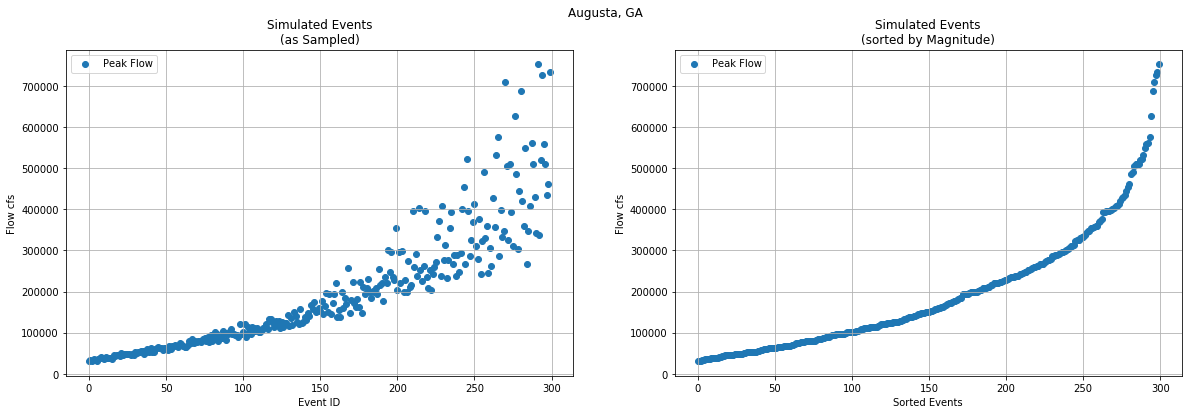

In [10]:
sim_Events(runs,sorted_runs) #Plot the unsorted and sorted simulated events

### 3. Calculate the weights for the AEPs:

#### using the range/number of AEPs from above:

In [11]:
df1=RI(min_val,max_val,nbin) #Calculate the recurrance interval given the minimum/maximum and number of recurrance intervals and return as a dataframe
df1.head()

,center
0,2.024376
1,2.074332
2,2.125520
3,2.177971
4,2.231717


In [12]:
df3=AEP_weights(df1,min_val,max_val) #Calculate the weight for each RI/AEP and add up the weight to make sure that it sums to 0.5

,ceiling,floor,weight
AEP,,,
0.493979,0.500000,0.487959,0.012375
0.482083,0.487959,0.476207,0.011751


None sum of weights: 0.5000000000000001


### 4. Calculate the mean discharge for each AEP:

In [13]:
AEP1=df3.index #Extract the annual exceedance probabilities from this dataframe

AEP1z=zvar(AEP1) #Transform this AEP to the standard normal z variate

table=ffc_summary(AEP1,AEP1z) #Construct a table with the AEP and the standard normal z variate of the AEP

table['Q_Mean_cfs'] = 10**table['AEPz'].apply(mean_Q(AEPmz,Q)) #Calculate the mean flow in cfs using the AEPmz and log Q from Step 1

table['Q_Median_cfs'] = 10**table['AEPz'].apply(median_Q(AEPz,data)) #Calculate the median flow in cfs  

table['RI']=1.0/table.index #Add a column to the table which is the recurrance interval

table.head()

,AEPz,Q_Mean_cfs,Q_Median_cfs,RI
AEP,,,,
0.493979,0.015092,33343.660819,32514.375082,2.024376
0.482083,0.044926,33920.070244,33135.941572,2.074332
0.470473,0.074081,34492.965222,33754.816697,2.125520
0.459143,0.102593,35062.613128,34371.253741,2.177971
0.448086,0.130500,35629.259102,34985.485020,2.231717


In [14]:
Q

array([3.76851231, 3.97185275, 4.17519319, 4.37853363, 4.58187407,
       4.78521451, 4.98855496, 5.1918954 , 5.39523584, 5.59857628,
       5.80191672, 6.00525716, 6.2085976 , 6.41193805, 6.61527849,
       6.81861893, 7.02195937, 7.22529981, 7.42864025, 7.63198069,
       7.83532114, 8.03866158, 8.24200202, 8.44534246, 8.6486829 ,
       8.85202334, 9.05536378, 9.25870422, 9.46204467, 9.66538511,
       9.86872555])

### 5. Find the events whose discharge is closest to the mean discharge at a given AEP and plot:

In [15]:
dic=eventIDs(table,runs,nevents) #Use the Q_mean_cfs from "table" and the "runs" dataframe to find the event IDs (nevents = number of events) whose discharge is closest to the mean at the RI

In [16]:
events=eventtable(table,dic) #Convert the dictionary of eventIDs to a dataframe
events.head()

,Events,RI
0,E002,2.024376
1,E005,2.074332
2,E005,2.125520
3,E005,2.177971
4,E007,2.231717


In [17]:
eventQs=eventQ(events,runs,dic, nevents) #Create a dataframe to store the event's discharge for each RI
eventQs.head()

,Value1,AEP
RI,,
2.024376,33400,49.397933
2.074332,34024,48.208299
2.231717,36548,44.808550
2.343220,36778,42.676319
2.401043,37013,41.648559


##### Plot the mean and median flow frequency curves with the events:

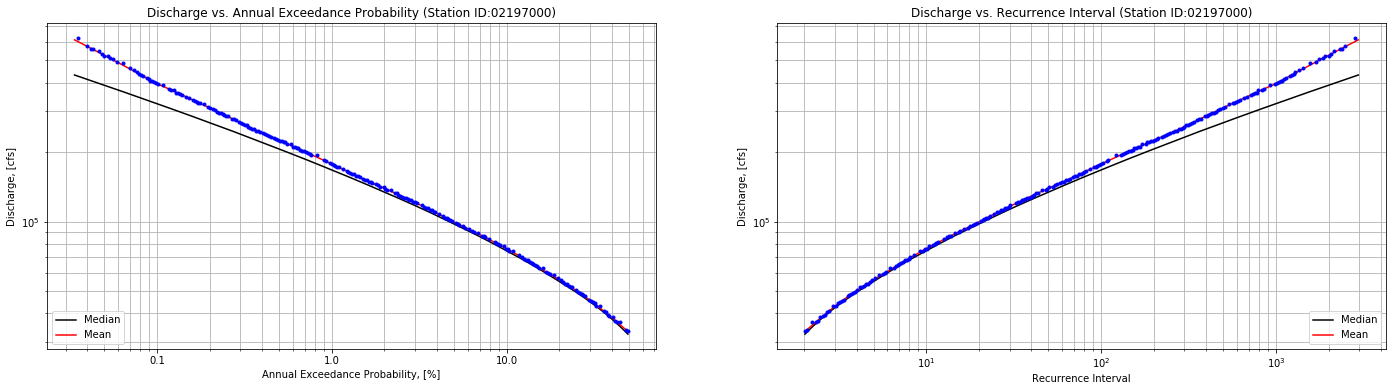

In [18]:
f=plot_ssp_meanmedffc_events(table, eventQs, gage_ID) #Plot the final mean and median flow frequency curves, witht the events from StratSamplerPOC.ipynb

### 6. Assign the weight for each event given its corresponding AEP/bin:

In [19]:
events=eventweight(events,df3,nevents) #Assign the weight to each event using the weight for that specific recurrance interval from step 3
events.head()

,Events,RI,weight
0,E002,2.024376,0.012375
1,E005,2.074332,0.011751
2,E005,2.125520,0.011468
3,E005,2.177971,0.011192
4,E007,2.231717,0.010923


### 7. Divide the total event weight into base/breach weights using the Augusta_Fluvial_weights.csv

In [20]:
df4=basebreach_format(pd.read_csv(r'sample_data\Augusta_Fluvial_weights.csv'))  #Load the three hundred events from Augustua_Fluvial_weights.csv 

Event=sorted(set(df4['Events'])) #Get a unique list of the event IDs

In [21]:
events['Events']=pd.to_numeric([events['Events'][i].replace('E','') for i in events.index]) #Remove the "E" from the name of the event and convert the event number to a integer

Eventsub=sorted(set(events['Events'])) #Get a unique list of the event IDs

In [22]:
df5=basebreach(events,df4,Event,Eventsub) #Divide the total event weight into the base/breach weights (wadjust) and check that the sum adds up to 0.5
df5.head()

0.49999999999999983


,Run,Weight,RunType,Events,Type,wtotal,prob,wadjust
1,Base_E002,0.011751,Base,2,Base,0.011751,1.0,0.012375
3,Base_E004,0.011192,Base,4,Base,0.011192,1.0,0.010152
4,Base_E005,0.010923,Base,5,Base,0.010923,1.0,0.034412
6,Base_E007,0.010403,Base,7,Base,0.010403,1.0,0.021582
7,Base_E008,0.010152,Base,8,Base,0.010152,1.0,0.009209


### 8. Adjust the weight of the breach scenarios and add the extra weight to the base:

In [24]:
len(Eventsub)

219

In [ ]:
df6=breachnorm(df5, Eventsub) #Adjust the weight of the breach scenarios

In [ ]:
path=os.path.join(os.getcwd(),'results/weighting_all') #Specify the location to save the results
if os.path.isdir(path)==False: #If the desired path does not exist, create it.
    os.mkdir(path)    
    
df6.to_csv(os.path.join(path,'weighting_all_%s.csv'%nbin)) #Save the results

# End